In [1]:
import astropy.io.fits as fits
import numpy as np
import path as Path
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rc('text', usetex = True)
#mpl.rc('font', family = 'serif')
import warnings
import scipy.special as spec
warnings.filterwarnings("ignore")
from itertools import cycle
from scipy.interpolate import interp1d
import weave
from weave import converters
import pickle
from IPython.core.debugger import Tracer
from astropy.table import Table
from ipywidgets import FloatProgress
from IPython.display import display
from multiprocessing import Process
from multiprocessing import Queue
from multiprocessing import Pool
import multiprocessing
import emcee
import corner
import pdb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import scipy
from escape_functions_noastropy import *
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
from __future__ import print_function
import time
import agama

In [2]:
aws = False

In [3]:
Omega_m = 0.25
Omega_L = 0.75
H0 = 73.0
h0 = H0/100.0
sizempc = 10.0 
binsmpc = 100.0
Msun=1.989e30
G_grav=6.67408e-11 
agama_N = 1000000
millennium_res = 8.61e8

In [4]:
def cosmology(cosmology):
    case = cosmology.name
    if case == 'Flatw0waCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.wa, cosmology.h]
    
    elif case == 'FlatwCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.h]

    elif case == 'wCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.w0,cosmology.h]
        
    elif case == 'LambdaCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.h]

    elif case == 'FlatLambdaCDM':
        return [cosmology.Om0, cosmology.h]

In [5]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=H0,Om0=Omega_m,name = cosmo_name)
cosmo_params = cosmology(cosmo)

In [6]:
filename = '/Users/christoq/100Halos/cmiller.csv'
dt = [('HaloId', long),('snapnum',long), ('px',float), ('py',float),('pz',float)]
cluster_list =  np.loadtxt(filename, dtype=dt,usecols = [0,1,2,3,4],delimiter=',',skiprows=1)
filenum = np.arange(100)

In [7]:
dt = [('HaloId', long),('subhaloid',long),('ra',float),('dec',float),('z',float),('r200crit',float),
      ('m200crit',float),('angulardistance',float),('vdispmean',float),('px',float),('py',float),('pz',float),
      ('vx',float),('vy',float),('vz',float),('r200mean',float),('m200mean',float)]
filename = '/Users/christoq/100Halos/biglosclusters.csv'
biglos =  np.loadtxt(filename, dtype=dt,delimiter=',',skiprows=1) 

In [8]:
dt = [('snap', long),('snapa', long), ('snapz',float)]
filename = '/Users/christoq/100Halos/snap_z_rev.dat'
snap =  np.loadtxt(filename, dtype=dt,delimiter=' ') 

In [9]:
root_density = '/Users/christoq/100Halos/DensityFits/'
dt = [('HaloId', long),('gamma',np.float),('gamma_err',float),('mass0',float),('mass0_err',float),('r_s',float),('rs_err',float)]
if (aws == False): 
    filename =  root_density + 'millenium_gam_concentrations.dat'
    density_gam =  np.loadtxt(filename, dtype=dt,skiprows=0) 

In [10]:
filename = root_density +'millenium_ein_concentrations.dat'
dt = [('HaloId',long), ('n',float), ('n_err',float),('rho_0',float),('rho_0_err',float),
      ('h',float),('h_err',float),('norm_ein',float)]
density_ein =  np.loadtxt(filename, dtype=dt,skiprows=0) 

In [12]:
clust_id = 10

In [13]:
w = np.where(cluster_list['HaloId'][clust_id] == biglos['HaloId'])
www = np.where(cluster_list['HaloId'][clust_id] == density_gam['HaloId'])
wwww = np.where(cluster_list['snapnum'][clust_id] == snap['snap'])
print(w,www,wwww)
a_halo =1.0/(1+(snap['snapz'][wwww])) # Calculate the scale factor at the redshift of the cluster
z_halo = 1/a_halo-1
print(a_halo, 1/a_halo-1)
#print cluster_list['HaloId'][i]
rrr = np.arange(0.1, 3.0, 0.01)
Ez = np.sqrt((Omega_m/( a_halo**3) + Omega_L + (1-Omega_m - Omega_L)/(a_halo**2.0))) # calculate Ez
Omega_Lz = Omega_L / (Ez**2.0) #Evolve Omega_L
Omega_mz = 1 - Omega_Lz #Evolve Omega_m
q = Omega_mz/2.0 - Omega_Lz #Calculate qz
Hz = np.sqrt(H0**2.0*Ez**2.0) #Calculate Hz
r200 =  biglos['r200crit'][w]*a_halo # Maybe use this?
m200 =  biglos['m200crit'][w]*(1e10)
Halo_v = [biglos['vx'][w],biglos['vy'][w],biglos['vz'][w]]
Halo_p = [biglos['px'][w],biglos['py'][w],biglos['pz'][w]] #Note: this is the position in the Guo snapshot. These are zero for particle fits (I.e., do not use with particles)
print('Halo ID: ', cluster_list['HaloId'][clust_id])
print('Mass(200), size(200), Hubble: ', m200, r200, Hz)

(array([31]),) (array([10]),) (array([59]),)
[0.91803086] [0.089288]
Halo ID:  477004683000004
Mass(200), size(200), Hubble:  [9.283818e+13] [0.71923651] [75.62191239]


In [14]:
Mass_0 = M_total(density_ein['rho_0'][www],density_ein['h'][www],density_ein['n'][www])
agama_res = Mass_0/agama_N
print(Mass_0)

[1.68290081e+14]


In [16]:
filename = '/Users/christoq/100Halos/particles//t' + str(clust_id) + '_cmiller.dat.fits' # Read in the particle data, where the particle positions have been recentered to the location of the cluster
particles = fits.getdata(filename)
ppx = particles['ppx']*a_halo # convert to physical coords
ppy = particles['ppy']*a_halo
ppz = particles['ppz']*a_halo
part_ppx = ppx
part_ppy = ppy
part_ppz = ppz
rpart = np.sqrt(ppx**2.0 + ppy**2.0 + ppz**2.0) # calculate particle radii
part_rpart = rpart
vvx = particles['vvx']*np.sqrt(a_halo) #Convert from Halo Finder units to physical units (only for particles)
vvy = particles['vvy']*np.sqrt(a_halo)
vvz = particles['vvz']*np.sqrt(a_halo)
wr200 = np.where(part_rpart < r200)[0]
Halo_mean_vvx = np.mean(vvx[wr200])
Halo_mean_vvy = np.mean(vvy[wr200])
Halo_mean_vvz = np.mean(vvz[wr200])
vvx = vvx - Halo_mean_vvx 
vvy = vvy - Halo_mean_vvy 
vvz = vvz - Halo_mean_vvz
part_vvx = vvx
part_vvy = vvy
part_vvz = vvz
part_vpart = np.sqrt((part_vvx)**2.0 + (part_vvy)**2.0 + (part_vvz)**2.0)
part_thetavec = np.arccos(part_ppz/np.sqrt(part_ppx**2.0 + part_ppy**2.0 + part_ppz**2.0))
part_phivec = np.arctan2(part_ppy,part_ppx)
part_vtheta = part_vvx*np.cos(part_thetavec)*np.cos(part_phivec) + part_vvy*np.cos(part_thetavec)*np.sin(part_phivec) - part_vvz*np.sin(part_thetavec)
part_vphi = -part_vvx*np.sin(part_phivec) + part_vvy*np.cos(part_phivec)
part_vrad = part_vvx*part_ppx/ part_rpart + part_vvy*part_ppy/part_rpart + part_vvz*part_ppz/part_rpart # calculate the radial component of the velocities
part_vflow = Hz*part_rpart
part_vr_tot = part_vrad + part_vflow # Add in the Hubble flow
part_vtan = np.sqrt(part_vtheta**2.0 + part_vphi**2.0)

In [18]:
root_guo = '/Users/christoq/100Halos/30Mpchalos/'
filename = str(cluster_list['HaloId'][clust_id]) + '.Guo30.fits' # Read in the galaxy data (brighter than m=-18), where the galaxy positions have NOT been recentered to the location of the cluster
galaxies2 = fits.getdata(root_guo + filename) 
bright = np.where(galaxies2['r_mag'] < -14.5)[0]
galaxies = galaxies2[bright]   
gal_ppx = ((galaxies['x'] - Halo_p[0])*a_halo) # convert to physical coords
gal_ppy = ((galaxies['y'] - Halo_p[1])*a_halo)
gal_ppz = ((galaxies['z'] - Halo_p[2])*a_halo)    
gal_rpart = np.sqrt(gal_ppx**2.0 + gal_ppy**2.0 + gal_ppz**2.0) # calculate particle radii
wr200 = np.where(gal_rpart < r200)[0]
gal_vvx = galaxies['velX'] - Halo_v[0] #move the particle velocities to be w/respect to the mean within r200crit
gal_vvy = galaxies['velY'] - Halo_v[1]
gal_vvz = galaxies['velZ'] - Halo_v[2]
gal_thetavec = np.arccos(gal_ppz/np.sqrt(gal_ppx**2.0 + gal_ppy**2.0 + gal_ppz**2.0))
gal_phivec = np.arctan2(gal_ppy,gal_ppx)
gal_vtheta = gal_vvx*np.cos(gal_thetavec)*np.cos(gal_phivec) + gal_vvy*np.cos(gal_thetavec)*np.sin(gal_phivec) - gal_vvz*np.sin(gal_thetavec)
gal_vphi = -gal_vvx*np.sin(gal_phivec) + gal_vvy*np.cos(gal_phivec)
gal_vrad = gal_vvx*gal_ppx/gal_rpart + gal_vvy*gal_ppy/gal_rpart + gal_vvz*gal_ppz/gal_rpart # calculate the radial component of the velocities
gal_vflow = Hz*gal_rpart
gal_vr_tot = gal_vrad + gal_vflow # Add in the Hubble flow
#vx3,vy3,vz3 = sphere2cart(rgal,thetavec,phivec,vr_tot,vtheta,vphi)
#v3d_gal = np.sqrt(vx3**2.0 + vy3**2.0 + vz3**2.0)
gal_vtan = np.sqrt(gal_vtheta**2.0 + gal_vphi**2.0)

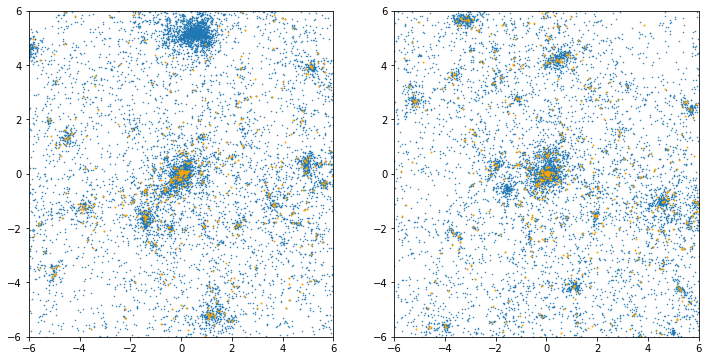

In [19]:
random = np.random.randint(0,len(part_ppx),100000,dtype='int64')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(part_ppx[random],part_ppy[random],'.',ms=1)
ax[0].plot(gal_ppx,gal_ppy,'o',ms=1,color='orange')
ax[1].plot(part_ppy[random],part_ppz[random],'.',ms=1)
ax[1].plot(gal_ppy,gal_ppz,'o',ms=1,color='orange')
ax[0].set_xlim(-6,6)
ax[0].set_ylim(-6,6)
ax[1].set_xlim(-6,6)
ax[1].set_ylim(-6,6)
plt.show()

In [20]:
agama.setUnits(mass=1, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1 Msun, gravitational constant: 4.30092e-06'

In [21]:
#agama_gam_pot = agama.Potential(type='Dehnen', mass=density_gam['mass0'][www], scaleradius=density_gam['r_s'][www]*1000.0, gamma = density_gam['gamma'][www],p=1,q=1)
#agama_gam_dens = agama.Density(type='Dehnen', mass=density_gam['mass0'][www], scaleradius=density_gam['r_s'][www]*1000.0, gamma = density_gam['gamma'][www],p=1,q=1)

In [22]:
agama_gam_pot = agama.Potential(type='Dehnen', mass=Mass_0/h0, scaleradius=density_gam['r_s'][www]*1000.0, gamma = density_gam['gamma'][www],p=1,q=1)
agama_gam_dens = agama.Density(type='Dehnen', mass=Mass_0/h0, scaleradius=density_gam['r_s'][www]*1000.0, gamma = density_gam['gamma'][www],p=1,q=1)

In [23]:
print(Mass_0, Mass_0/h0)

[1.68290081e+14] [2.30534358e+14]


In [24]:
#agama_gam_pot = agama.Potential(type='NFW', mass=density_gam['mass0'][www], scaleradius=density_gam['r_s'][www]*1000.0, gamma = density_gam['gamma'][www],p=1,q=1)
#agama_gam_dens = agama.Density(type='NFW', mass=density_gam['mass0'][www], scaleradius=density_gam['r_s'][www]*1000.0, gamma = density_gam['gamma'][www],p=1,q=1)

In [25]:
radial_bins = 20
print(density_gam['mass0'][www],density_gam['r_s'][www],density_gam['gamma'][www])
my_radius_array = np.linspace(0.05,5.0,radial_bins).round(3)
my_dens = rho_dehnen(my_radius_array,density_gam['mass0'][www],density_gam['r_s'][www],density_gam['gamma'][www])

[1.643854e+13] [0.3400425] [0.871472]


In [26]:
df = agama.DistributionFunction(type='QuasiSpherical',density=agama_gam_dens, potential=agama_gam_pot, beta0=-0.5)
# draw samples from the DF
posvel,mass = agama.GalaxyModel(agama_gam_pot, df).sample(agama_N)

In [27]:
Ez = np.sqrt((Omega_m/( a_halo**3) + Omega_L + (1-Omega_m - Omega_L)/(a_halo**2.0))) # calculate Ez
Omega_Lz = Omega_L / (Ez**2.0) #Evolve Omega_L
Omega_mz = 1 - Omega_Lz #Evolve Omega_m
q = Omega_mz/2.0 - Omega_Lz #Calculate qz
Hz = np.sqrt(H0**2.0*Ez**2.0) #Calculate Hz
agama_ppx = posvel[:,0]/1000.0
agama_ppy = posvel[:,1]/1000.0
agama_ppz = posvel[:,2]/1000.0
agama_vvx = posvel[:,3]
agama_vvy = posvel[:,4]
agama_vvz = posvel[:,5]
agama_rpart = np.sqrt(agama_ppx**2.0 + agama_ppy**2.0 + agama_ppz**2.0) # calculate particle radii
agama_vpart = np.sqrt((agama_vvx)**2.0 + (agama_vvy)**2.0 + (agama_vvz)**2.0)
agama_thetavec = np.arccos(agama_ppz/np.sqrt(agama_ppx**2.0 + agama_ppy**2.0 + agama_ppz**2.0))
agama_phivec = np.arctan2(agama_ppy,agama_ppx)
agama_vtheta = agama_vvx*np.cos(agama_thetavec)*np.cos(agama_phivec) + agama_vvy*np.cos(agama_thetavec)*np.sin(agama_phivec) - agama_vvz*np.sin(agama_thetavec)
agama_vphi = -agama_vvx*np.sin(agama_phivec) + agama_vvy*np.cos(agama_phivec)
agama_vrad = (agama_vvx*agama_ppx + agama_vvy*agama_ppy +agama_vvz*agama_ppz)/agama_rpart # calculate the radial component of the velocities
agama_vflow = Hz*agama_rpart
agama_vr_tot = agama_vrad + agama_vflow # Add in the Hubble flow
agama_vtan = np.sqrt((agama_vphi**2 + agama_vtheta**2.0)/1.0)
agama_v3d = np.sqrt((agama_vtan**2/1.0 + agama_vr_tot**2.0))
#v3d = vpart
#np.arctan2()

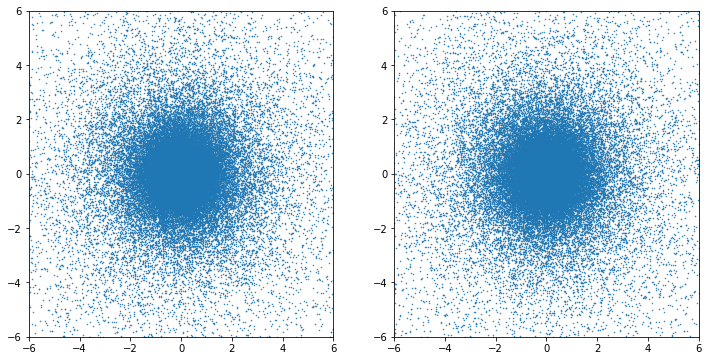

In [28]:
random = np.random.randint(0,len(agama_ppx),100000,dtype='int64')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(agama_ppx[random],agama_ppy[random],'.',ms=1)
ax[1].plot(agama_ppy[random],agama_ppz[random],'.',ms=1)
ax[0].set_xlim(-6,6)
ax[0].set_ylim(-6,6)
ax[1].set_xlim(-6,6)
ax[1].set_ylim(-6,6)
plt.show()

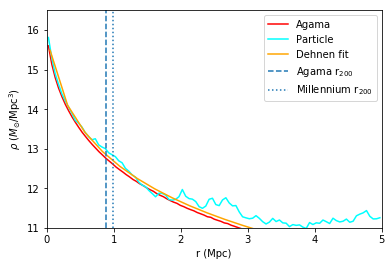

In [29]:
x = np.linspace(0,9.95,200) + 0.05
agama_r_vescmax = np.zeros((100))
agama_rho_vescmax = np.zeros((100))
dens_radius_bookends = np.linspace(0,5,100)
agama_density = []
agama_cumul_density = []
agama_dens_radius = []
for i in range(99):
    agama_dens_radius = np.append(agama_dens_radius, (dens_radius_bookends[i+1] + dens_radius_bookends[i])/2.0)
    volume = 4./3.*np.pi*(dens_radius_bookends[i+1]**3.0 - dens_radius_bookends[i]**3.0 )
    count = len(np.where((agama_rpart > dens_radius_bookends[i]) & (agama_rpart < dens_radius_bookends[i+1]))[0])
    agama_density = np.append(agama_density,count*agama_res/volume)
    count = len(np.where((agama_rpart < dens_radius_bookends[i+1]))[0])
    volume = 4./3.*np.pi*(dens_radius_bookends[i+1]**3.0)
    agama_cumul_density = np.append(agama_cumul_density, count*agama_res/volume)
    
#for j in range(0,int(binsmpc) - 1):
#  wless =  np.where(agama_rpart <  float(j+1)/sizempc)
#  nless = len(wless)
#  win = np.where((agama_rpart >=  float(j)/sizempc) & (agama_rpart <= float(j+1)/sizempc) )[0]
#  nin = len(win)
#  volume = 4.0/3.0*np.pi*((float(j+1)/sizempc)**3.0- (float(j)/sizempc)**3.0)
#  agama_r_vescmax[j] = float(j)/sizempc+0.025
#  m_vescmax = float(nless)*agama_res
#  agama_rho_vescmax[j] = float(nin)*agama_res/volume 
plt.plot(agama_dens_radius,np.log10(agama_density) ,'r',label='Agama')
plt.xlim(0,5)
plt.ylim(11,16.5)
filename = '/Users/christoq/100Halos/DensityFits/rprof_vescmax.fits'
r_vescmax = fits.getdata(filename)
filename = '/Users/christoq/100Halos/DensityFits/rhoprof_vescmax.fits' 
density = fits.getdata(filename)
plt.plot(r_vescmax[www][0],np.log10(density[www][0]),'cyan',label='Particle')
plt.plot(my_radius_array, np.log10(my_dens), 'orange',label='Dehnen fit')
plt.legend()
plt.xlabel('r (Mpc)')
plt.ylabel(r'$\rho$ ($M_{\odot}$/Mpc$^3$)')
rho_crit = cosmo.critical_density(0)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
agama_r200 = agama_dens_radius[np.where(agama_cumul_density < 200*rho_crit.value)[0][0]]
plt.axvline(agama_r200,linestyle='--', label=r'Agama r$_{200}$')
plt.axvline(r200/h0,linestyle=':', label=r'Millennium r$_{200}$')
plt.legend()

#plt.axhline(np.log10(rho_crit.value*200.))#only works for CUMULATIVE density
plt.show()

In [30]:
rho_0 = np.resize(density_ein['rho_0'][www],(1,len(z_halo)))
h = np.resize(density_ein['h'][www],(1,len(z_halo)))
n = np.resize(density_ein['n'][www], (1,len(z_halo)))
print('Cluster Einasto rho_0, h, and n parameters: ',rho_0, h,n)

Cluster Einasto rho_0, h, and n parameters:  [[3.096876e+17]] [[0.00030712]] [[3.363091]]


In [31]:
cosmo_name = 'LambdaCDM'
cosmo = LambdaCDM(H0=73, Om0=0.25, Ode0 = 0.75, name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.repeat(z_halo,(1))
num_clus = len(z)
members = np.where((part_rpart > 0.3*r200) & (part_rpart < 1.0*r200))[0]
print(len(members))
N = np.repeat(len(members),len(z))
radial_bins = 10
radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
vesc_data_theta = np.zeros((len(z),radial_bins))
for i in range(len(z)): #These are the escape velocity arrays in angular (not physical) units.
    vesc_data_theta[i] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value 
r_Om02Ode08_EIN,vesc_Om02Ode08_EIN = v_esc_einasto(vesc_data_theta,z,rho_0,h,n,N,cosmo_params, cosmo_name,num_clus)
print(r_Om02Ode08_EIN,vesc_Om02Ode08_EIN)

73369
[[0.1   0.311 0.522 0.733 0.944 1.156 1.367 1.578 1.789 2.   ]] [[1796.8757789  1454.40008277 1235.40068629 1077.02254786  954.27020324
   854.30734853  771.02066557  699.54501203  637.01686611  581.45873118]]


In [32]:
cosmo_name = 'LambdaCDM'
cosmo = LambdaCDM(H0=73, Om0=0.25, Ode0 = 0.75, name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.repeat(z_halo,(1))
num_clus = len(z)
members = np.where((agama_rpart > 0.3*r200) & (agama_rpart < 1.0*r200))[0]
print(len(members))
N = np.repeat(len(members),len(z))
radial_bins = 10
radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
vesc_data_theta = np.zeros((len(z),radial_bins))
for i in range(len(z)): #These are the escape velocity arrays in angular (not physical) units.
    vesc_data_theta[i] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value 
agama_r_Om02Ode08_EIN,agama_vesc_Om02Ode08_EIN = v_esc_einasto(vesc_data_theta,z,rho_0,h,n,N,cosmo_params, cosmo_name,num_clus)
print(agama_r_Om02Ode08_EIN,agama_vesc_Om02Ode08_EIN)

305143
[[0.1   0.311 0.522 0.733 0.944 1.156 1.367 1.578 1.789 2.   ]] [[1812.83768766 1467.31973014 1246.37493018 1086.58989572  962.74712418
   861.8962849   777.86975423  705.75917207  642.67557954  586.62391362]]


In [33]:
cosmo_name = 'LambdaCDM'
cosmo = LambdaCDM(H0=73, Om0=0.25, Ode0 = 0, name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.repeat(z_halo,(1))
num_clus = len(z)
members = np.where((agama_rpart > 0.3*r200) & (agama_rpart < 1.0*r200))[0]
print(len(members))
N = np.repeat(len(members),len(z))
radial_bins = 10
radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
vesc_data_theta = np.zeros((len(z),radial_bins))
for i in range(len(z)): #These are the escape velocity arrays in angular (not physical) units.
    vesc_data_theta[i] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value 
agama_r_Om02Ode00_EIN,agama_vesc_Om02Ode00_EIN = v_esc_einasto(vesc_data_theta,z,rho_0,h,n,N,cosmo_params, cosmo_name,num_clus)
print(agama_r_Om02Ode00_EIN,agama_vesc_Om02Ode00_EIN)

305143
[[0.1   0.311 0.522 0.733 0.944 1.156 1.367 1.578 1.789 2.   ]] [[1906.10243667 1581.01434338 1378.21942393 1235.27368221 1127.39374325
  1041.93564328  972.73218404  915.0466813   866.06015807  823.82995448]]


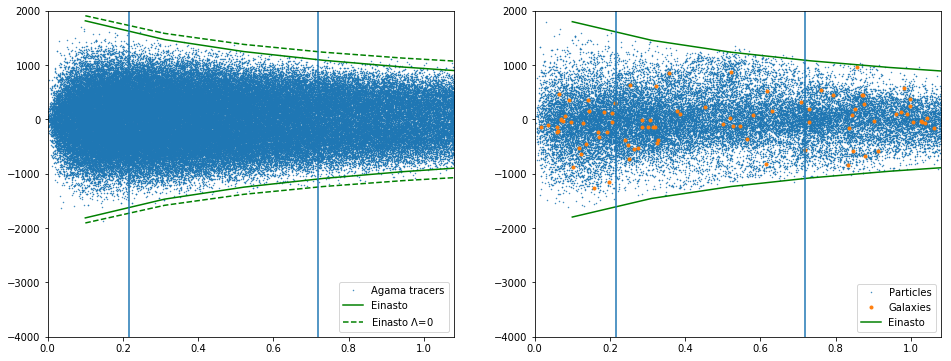

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
random = np.random.randint(0,len(agama_rpart),200000,dtype='int64')
ax[0].plot(agama_rpart[random], agama_vtheta[random], '.', ms=0.9,label = 'Agama tracers')
random = np.random.randint(0,len(part_rpart),3000000,dtype='int64')
ax[1].plot(part_rpart[random], part_vtheta[random], '.',ms=0.9, label = 'Particles')

ax[1].plot(gal_rpart, gal_vtheta, '.', label = 'Galaxies')
for i in range(len(z)):
    ax[0].plot(agama_r_Om02Ode08_EIN[i],agama_vesc_Om02Ode08_EIN[i],'g-', label = 'Einasto ')
    ax[0].plot(agama_r_Om02Ode08_EIN[i],-agama_vesc_Om02Ode08_EIN[i],'g-')
    ax[0].plot(agama_r_Om02Ode00_EIN[i],agama_vesc_Om02Ode00_EIN[i],'g--', label = r'Einasto $\Lambda$=0 ')
    ax[0].plot(agama_r_Om02Ode00_EIN[i],-agama_vesc_Om02Ode00_EIN[i],'g--')
    ax[1].plot(r_Om02Ode08_EIN[i],vesc_Om02Ode08_EIN[i],'g-', label = 'Einasto ')
    ax[1].plot(r_Om02Ode08_EIN[i],-vesc_Om02Ode08_EIN[i],'g-')
ax[0].set_xlim(0,1.5*r200)
ax[0].set_ylim(-4000,2000)
ax[1].set_xlim(0,1.5*r200)
ax[1].set_ylim(-4000,2000)
ax[0].axvline(0.3*r200)
ax[0].axvline(r200)
ax[1].axvline(0.3*r200)
ax[1].axvline(r200)
ax[0].legend()
ax[1].legend()
plt.show()